# Predicting Insurance Costs with Linear Regression

This project uses an insurance cost data set from Kaggle (https://www.kaggle.com/datasets/mirichoi0218/insurance). It contains information on individual medical insurance bills. Each bill is associated with some characteristics of the person who received it:

- age: age of primary beneficiary
- sex: insurance contractor gender, female, male
- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
- children: Number of children covered by health insurance / Number of dependents
- smoker: if person is smoking (yes/no)
- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- charges: Individual medical costs billed by health insurance

We are interested in how these different characteristics relate to the total medical cost. Since it is a continuous, positive number, a linear regression is promising to bring us some good results. 

First we import all libraries needed to build and test the linear regression model and to analyze and visualize the data. Right after we start to explore the data

In [87]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

## Explore the data

In [88]:
insurance = pd.read_csv("insurance.csv")
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [89]:
insurance.info()
insurance.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


The data set seems to be very clean. There are no missing values and no questionable high outliers. However the charges apear not be in a normal distribution. We take a closer look.

array([[<AxesSubplot:title={'center':'charges'}>]], dtype=object)

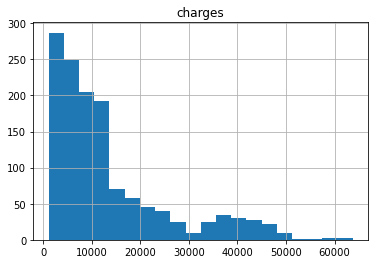

In [90]:
insurance.hist("charges", bins=20)

The distribution is clearly right-skewed. The probability of having very high costs is quite high. This makes it unlikely that the errors of our model will be scattered evenly around zero, which is a pre-condition for a good linear regression. It might be worth to log-transform the outcome to make it closer to a normal distribution.

array([[<AxesSubplot:title={'center':'log_charges'}>]], dtype=object)

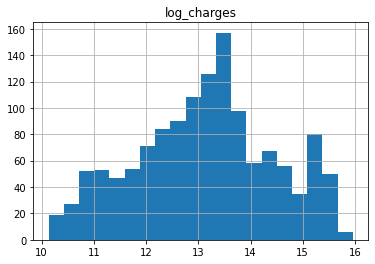

In [91]:
insurance["log_charges"] = np.log2(insurance["charges"])

insurance.hist("log_charges", bins=20)

### Correlations

It worked well, so now we can have a look on how the features correlate with charges to choose the predictors for our model. To also cover up the categorical columns we first have to encode their values into integers.

<AxesSubplot:>

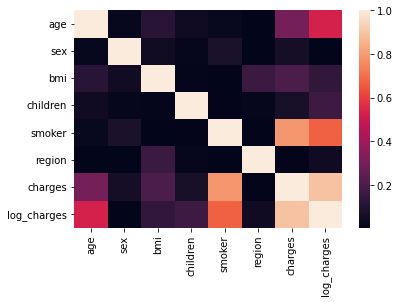

In [92]:
ordinal_encoder = OrdinalEncoder()
encoded_data = ordinal_encoder.fit_transform(insurance[["sex", "smoker", "region"]])

insurance["sex"] = encoded_data[:, 0]
insurance["smoker"] = encoded_data[:, 1]
insurance["region"] = encoded_data[:, 2]

sns.heatmap(abs(insurance.corr()), annot=False)

The biggest correlations are with smoking and age. There also seems to be a small correlation with BMI and number of children. Let's look at the relationships in more detail.

<AxesSubplot:xlabel='smoker', ylabel='log_charges'>

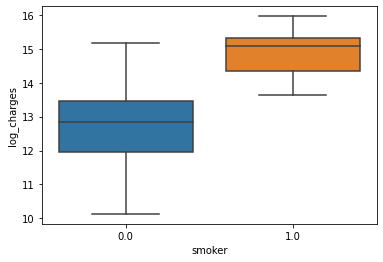

In [93]:
sns.boxplot(data=insurance, y="log_charges", x="smoker")

As expected smokers tend to have much higher charges.

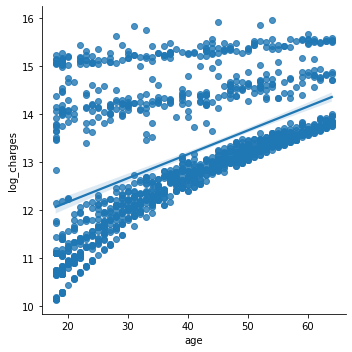

In [94]:
sns.lmplot(x = 'age', y = 'log_charges', data=insurance)

A linear relationship can be seen, but the relationship appears to be bipartite. This may be due to another influencing variable. Since smoking seems to have the biggest impact, we try to show an influence.

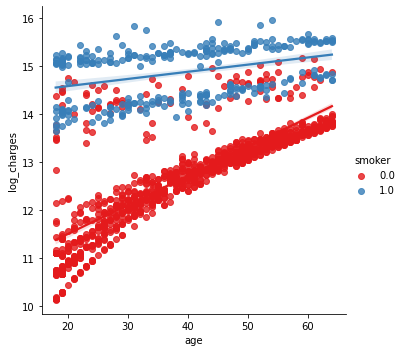

In [95]:
sns.lmplot(x = 'age', y = 'log_charges', data=insurance, hue='smoker', palette='Set1')

The assumption has come true. A linear progression can be seen for both non-smokers and smokers. However, the influence of age seems to be less for smokers, which can be seen from the lower slope of the line.

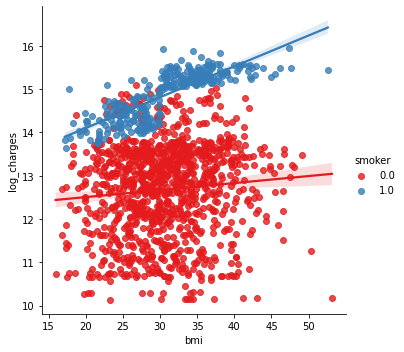

In [96]:
sns.lmplot(x = 'bmi', y = 'log_charges', data=insurance, hue='smoker', palette='Set1')

In fact, BMI does not appear to have a large impact on costs. However, it looks like the combination of high BMI and smoking is particularly bad.

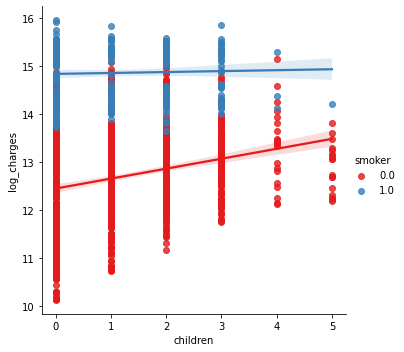

In [97]:
sns.lmplot(x = 'children', y = 'log_charges', data=insurance, hue='smoker', palette='Set1')

The risk of expensive treatments seems to increase with the number of children. For smokers, however, this effect is rather small.

## Linear Regression

### Train first model

Initially, we will train our model only with the two clearly correlating variables smoking and age. However, we later will test whether a better result can be achieved by adding more of the other variables.

Let's start to build the model by splitting the data into training and test set. We also normalize the data with the MinMaxScaller.

In [98]:
X = insurance[["age","smoker"]]
y = insurance["log_charges"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)

minmax = MinMaxScaler()
X_train = minmax.fit_transform(X_train)
X_test = minmax.transform(X_test)

model = LinearRegression()
model.fit(X_train,y_train)

coef = model.coef_
intercept = model.intercept_
print("intercept:", intercept)
print("coefficients:", coef)

y_train_pred = model.predict(X_train)

mse_train = mean_squared_error(y_train, y_train_pred)
me_train = mean_squared_error(y_train, y_train_pred, squared=False)
print("Mean squared error (MSE):", mse_train)

r2_train = r2_score(y_train, y_train_pred)
print("Coefficient of determination:", r2_train)

intercept: 11.606229545877984
coefficients: [2.32609865 2.2176697 ]
Mean squared error (MSE): 0.4593693672343017
Coefficient of determination: 0.7358098656135421


The MSE of the training set ist 0.459 und the coefficient of determination is 0,736, which is very promising. It indicates that the model can explain 73,6% of the variation in the insurance charges.

### Feature Selection

To test if there is a better combinations of predictors/features for our model we will use Sequential Forward Selection (SFS) and Sequential Backward Selection (SBS) 

In [99]:
from sklearn.feature_selection import SequentialFeatureSelector as SFS

X = insurance.drop(["charges","log_charges"], axis=1)
y = insurance["log_charges"]

model_sfs = LinearRegression()

print("R²   features")

for i in range(1,len(X.columns)):
    sfs = SFS(model_sfs, n_features_to_select=i, direction='forward', scoring='r2')
    sfs.fit(X,y)
    var_sfs = sfs.get_feature_names_out()
    
    X_var = insurance[var_sfs]
    model.fit(X_var,y)
    y_pred = model.predict(X_var)
    r2_train = r2_score(y, y_pred)   
        
    print(round(r2_train,2), var_sfs)

R²   features
0.44 ['smoker']
0.74 ['age' 'smoker']
0.76 ['age' 'children' 'smoker']
0.76 ['age' 'bmi' 'children' 'smoker']
0.77 ['age' 'bmi' 'children' 'smoker' 'region']


In [100]:
model_sbs = LinearRegression()

print("R²   features")

for i in range(1,len(X.columns)):
    sbs = SFS(model_sbs, n_features_to_select=i, direction='backward', scoring='r2')
    sbs.fit(X,y)
    var_sbs = sbs.get_feature_names_out()
    
    X_var = insurance[var_sbs]
    model.fit(X_var,y)
    y_pred = model.predict(X_var)
    r2_train = r2_score(y, y_pred)   
        
    print(round(r2_train,2), var_sbs)

R²   features
0.44 ['smoker']
0.74 ['age' 'smoker']
0.76 ['age' 'children' 'smoker']
0.76 ['age' 'bmi' 'children' 'smoker']
0.77 ['age' 'bmi' 'children' 'smoker' 'region']


Both selectors recommend to use all available features, while smoker and age are most important. The improvement from adding more features however isn't really high. 

In [101]:
X = insurance[['age', 'bmi', 'children', 'smoker', 'region']]
y = insurance["log_charges"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)

minmax = MinMaxScaler()
X_train = minmax.fit_transform(X_train)
X_test = minmax.transform(X_test)

model = LinearRegression()
model.fit(X_train,y_train)

coef = model.coef_
intercept = model.intercept_
print("intercept:", intercept)
print("coefficients:", coef)

y_train_pred = model.predict(X_train)

mse_train = mean_squared_error(y_train, y_train_pred)
me_train = mean_squared_error(y_train, y_train_pred, squared=False)
print("Mean squared error (MSE):", mse_train)

r2_train = r2_score(y_train, y_train_pred)
print("Coefficient of determination:", r2_train)

intercept: 11.332888654831743
coefficients: [ 2.27872808  0.61979096  0.70775344  2.22559048 -0.2118588 ]
Mean squared error (MSE): 0.41722132294899
Coefficient of determination: 0.7600498308313


Indeed we could improve the determination slightly to 76,0%.

### Checking assumptions of linear regression

Additionaly we should check if the model fits the assumptions of linear regression:
- Do the residuals seem to center around 0 over the range of the fitted values?
- Do the residuals seem to remain in a constant "band" around 0 over the range of fitted values? If not, what does the trend look like?

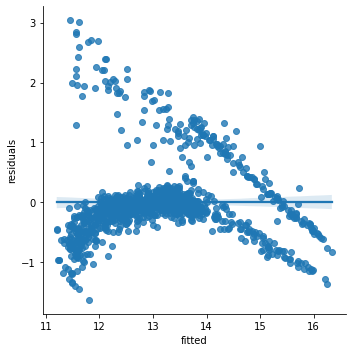

In [102]:
check_model = pd.DataFrame()
check_model["residuals"] = y_train - y_train_pred
check_model["fitted"] = y_train_pred

sns.lmplot(x = 'fitted', y = 'residuals', data=check_model, palette='Set1')

As fitted values get larger, the residuals trend downward. So the residuals are not perfectly centered in a constant band around zero. Our model seems to have some difficulties at the upper and lower range of values. At the bottom we overestimate the costs and at the top we underestimate them. This does not necessarily make the model predictions unusable, but it puts into question if linear regression is the right model here.

### Test the model

In [103]:
y_test_pred = model.predict(X_test)

mse_test = mean_squared_error(y_test, y_test_pred)
print("Mean squared error (MSE):", mse_test)

r2_test = r2_score(y_test, y_test_pred)
print("Coefficient of determination:", r2_test)

Mean squared error (MSE): 0.3953745237300253
Coefficient of determination: 0.784811921222497


The MSE of the test set (0.39) is even smaller than the one of the training set (0.42). Since the errors match up pretty well, we can conclude that the model is not overfitted. The coefficient of determination is therefore also higher with 78,5%.

## Clustering the data

Probably we get better results when dividing the data into clusters and do a linear regression for each cluster.

We have to create several KMeans models and compute the inertia from each of them. Then, we'll be able to plot the Elbow Curve and decide the number of clusters we'll use to segment the customers.

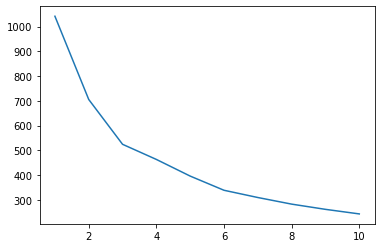

In [104]:
insurance_cluster = insurance

minmax = MinMaxScaler()

minmax.fit(insurance_cluster.drop(["charges"], axis=1))
insurance_cluster_scaled = minmax.transform(insurance_cluster.drop(["charges"], axis=1))

from sklearn.cluster import KMeans

inertias = []

for k in range(10):
    kmeans = KMeans(n_clusters=k+1)
    cluster = kmeans.fit_predict(insurance_cluster_scaled)
    inertias.append(kmeans.inertia_)
    
plt.plot(range(1,11),inertias)
plt.show()

There is a well noticeable "elbow" in the curve for 3 clusters. However we will also test 2 and 4 clusters.

In [105]:
print("k n MSE  R²")

for k in range(2,5):
    model = KMeans(n_clusters=k)
    cluster = model.fit_predict(insurance_cluster_scaled)
    insurance_cluster["cluster"] = cluster

    for n in range(k):
        insurance_n = insurance_cluster[insurance_cluster["cluster"]==n]

        X = insurance_n.drop(["charges","log_charges"], axis=1)
        y = insurance_n["log_charges"]

        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)

        minmax = MinMaxScaler()
        X_train = minmax.fit_transform(X_train)
        X_test = minmax.transform(X_test)

        model = LinearRegression()
        model.fit(X_train,y_train)
        
        y_train_pred = model.predict(X_train)
        r2_train = r2_score(y_train, y_train_pred)
        mse_train = mean_squared_error(y_train, y_train_pred)
        
        print(k, n, round(mse_train,2), round(r2_train,3))

k n MSE  R²
2 0 0.45 0.785
2 1 0.39 0.731
3 0 0.41 0.693
3 1 0.31 0.699
3 2 0.07 0.766
4 0 0.41 0.693
4 1 0.31 0.699
4 2 0.07 0.745
4 3 0.06 0.803


The coefficient of determination unfortunately doesn't increased for the clustered data. There is only one cluster with over 80% when we split the data in 4 clusters. Let's take a look at how the clusters are characterized there.

<AxesSubplot:xlabel='sex', ylabel='log_charges'>

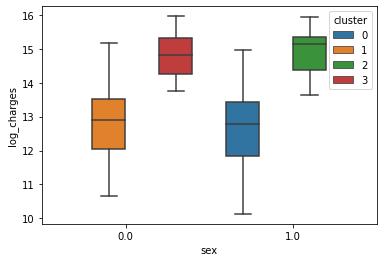

In [106]:
sns.boxplot(data=insurance_cluster, y="log_charges", x="sex", hue='cluster')

<AxesSubplot:xlabel='smoker', ylabel='log_charges'>

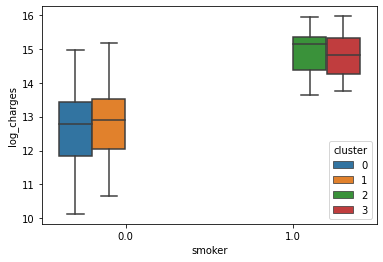

In [107]:
sns.boxplot(data=insurance_cluster, y="log_charges", x="smoker", hue='cluster')

The data is splitted in smoking and non-smoking females and smoking and non-smoking males. The data for males (especially smokers) seem to have a stronger linear relation, since we got the highest R² for it.

By examining the feature combinations, we try to improve the results of the clustered data one last time. Again we will use the Sequential Forward Selection.

In [108]:
k = 4

model = KMeans(n_clusters=k)
cluster = model.fit_predict(insurance_cluster_scaled)
insurance_cluster["cluster"] = cluster

print("Cluster R²   features")

for n in range(k):
    insurance_n = insurance_cluster[insurance_cluster["cluster"]==n]

    X = insurance_n.drop(["charges","log_charges"], axis=1)
    y = insurance_n["log_charges"]

    model_sfs = LinearRegression()

    for i in range(1,len(X.columns)):
        sfs = SFS(model_sfs, n_features_to_select=i, direction='forward', scoring='r2')
        sfs.fit(X,y)
        var_sfs = sfs.get_feature_names_out()

        X_var = X[var_sfs]
        minmax = MinMaxScaler()
        X_var = minmax.fit_transform(X_var)
        
        model = LinearRegression()
        model.fit(X_var,y)
        y_pred = model.predict(X_var)
        r2_train = r2_score(y, y_pred)   

        print(n, "     ", round(r2_train,2), var_sfs)

Cluster R²   features
0       0.64 ['age']
0       0.69 ['age' 'children']
0       0.7 ['age' 'children' 'region']
0       0.7 ['age' 'sex' 'children' 'region']
0       0.7 ['age' 'sex' 'children' 'smoker' 'region']
0       0.7 ['age' 'sex' 'children' 'smoker' 'region' 'cluster']
1       0.63 ['age']
1       0.67 ['age' 'children']
1       0.68 ['age' 'children' 'region']
1       0.68 ['age' 'sex' 'children' 'region']
1       0.68 ['age' 'sex' 'children' 'smoker' 'region']
1       0.68 ['age' 'sex' 'children' 'smoker' 'region' 'cluster']
2       0.6 ['bmi']
2       0.73 ['age' 'bmi']
2       0.73 ['age' 'bmi' 'smoker']
2       0.73 ['age' 'bmi' 'smoker' 'cluster']
2       0.73 ['age' 'sex' 'bmi' 'smoker' 'cluster']
2       0.73 ['age' 'sex' 'bmi' 'children' 'smoker' 'cluster']
3       0.7 ['bmi']
3       0.78 ['age' 'bmi']
3       0.78 ['age' 'sex' 'bmi']
3       0.78 ['age' 'sex' 'bmi' 'smoker']
3       0.78 ['age' 'sex' 'bmi' 'smoker' 'cluster']
3       0.78 ['age' 'sex' 'bmi' 'child

Like before, the best results are obtained when all features are used. Unfortunately, we didn't get any further with the approach of using clustering. In order to enable even better predictions, a method other than linear regression should be considered.